In [1]:
''' Python packages '''
import numpy as np
from matplotlib import pyplot as plt

''' Project specific tools '''
from data_management import *
from models import *
from display import *
from metrics import *

''' Display configs '''
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_man = DataManager('BioPlex_PU_data.pkl')

In [4]:
P, U, _, _ = data_man.parse_pickle()

In [130]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, normalize=True)

In [131]:
X_norm = np.concatenate((x_train, x_test))

In [133]:
fig = FigureDrawer('Feature distributions')
fig.draw_hist_array(X_norm.T)

In [5]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns

In [139]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=45000, PU_ratio=100., normalize=True, show_counts=True)

TypeError: split_training_test() got an unexpected keyword argument 'show_counts'

In [137]:
tsne = TSNE(n_jobs=6, perplexity=50, learning_rate=100, early_exaggeration=16, n_iter=5000) # n_iter=2000
X_embedded = tsne.fit_transform(x_train)
x_tsne = X_embedded[::-1]

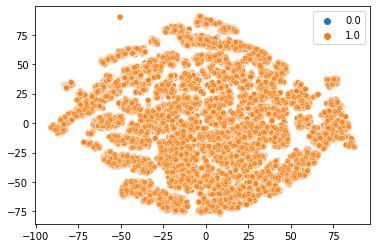

In [138]:
sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=t_train[::-1], legend='full', alpha=0.5)

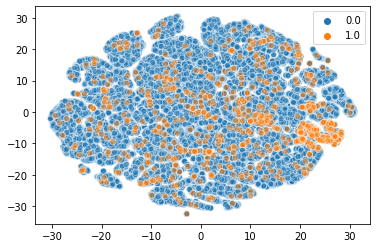

In [129]:
sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=t_train[::-1], legend='full', alpha=0.5)

In [82]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=0.8, normalize=True)

In [96]:
lm = Model('linear', C=1, M=6, niter=5000)

In [84]:
X_train_hd = lm.polynomial_basis_fun(x_train)

In [85]:
X_test_hd = lm.polynomial_basis_fun(x_test)

In [88]:
lm.train(X_train_hd, t_train)

In [90]:
t_pred = lm.predict(X_test_hd)

In [91]:
metrics.accuracy(t_pred, t_test)

0.8880940556234719

In [92]:
metrics.recall(t_pred, t_test)

0.4091307012168432

In [93]:
mlp = Model('MLP', neuron_per_layer=(50, 40, 30, 20, 10), niter=2000)
mlp.train(x_train, t_train)
t_pred = mlp.predict(x_test)

/home/seb/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [7]:
metrics = Metrics()

In [94]:
metrics.accuracy(t_pred, t_test)

0.8665125814995925

In [95]:
metrics.recall(t_pred, t_test)

0.48174735183401907

In [52]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.95, normalize=True)

In [53]:
mlp = Model('svm_rbf')
mlp.train(x_train, t_train)
t_pred = mlp.predict(x_test)

In [54]:
metrics.accuracy(t_pred, t_test)

0.8705275310932002

In [55]:
metrics.recall(t_pred, t_test)

0.3894302762227291